# Deep Learning Convulitional Neural Network with TensorFlow

In [21]:
!pip install --upgrade tensorflow

In [22]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.12.0
Keras version: 2.12.0


### Data Preprocessing

3 classes:
['circle', 'square', 'triangle']


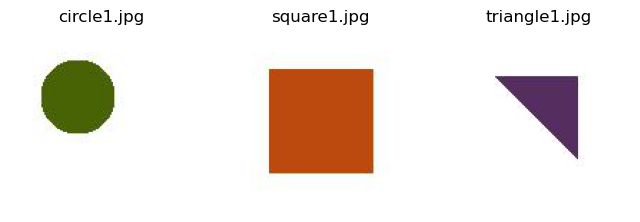

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

data_folder = 'data/shapes'

classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

### Data Understanding

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3)
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
Data generators ready


### Data Modeling CNN

In [25]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 32)      

### Train the Model

In [26]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
28/28 [==============================] - 32s 1s/step - loss: 0.7262 - accuracy: 0.6560 - val_loss: 0.3629 - val_accuracy: 0.7528
Epoch 2/5
28/28 [==============================] - 24s 851ms/step - loss: 0.1927 - accuracy: 0.9286 - val_loss: 0.0400 - val_accuracy: 0.9833
Epoch 3/5
28/28 [==============================] - 23s 830ms/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.0106 - val_accuracy: 0.9972
Epoch 4/5
28/28 [==============================] - 23s 816ms/step - loss: 0.0126 - accuracy: 0.9964 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 23s 817ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0029 - val_accuracy: 1.0000


### Review Loss History

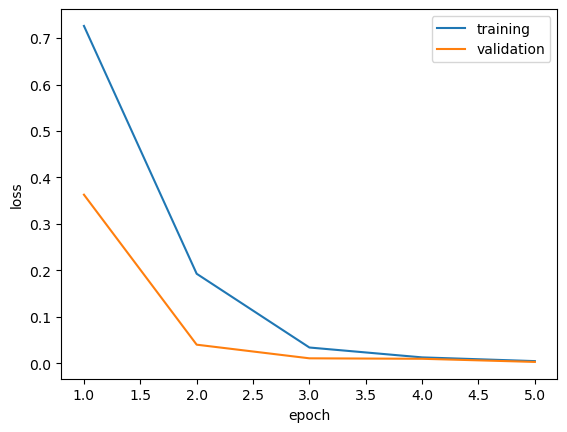

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate Model Performance

Generating predictions from validation data...
1/1 [==============================] - 0s 313ms/step


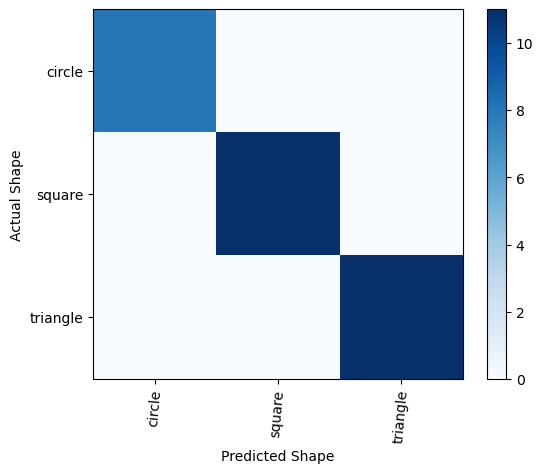

In [28]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

### Save Train Model

In [29]:
# Save the trained model
modelFileName = 'models/shape_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as models/shape_classifier.h5


### Use model trained 

1/1 [==============================] - 0s 110ms/step
square


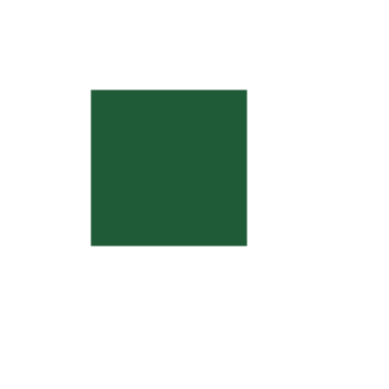

In [33]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
model = models.load_model(modelFileName) # loads the saved model
class_idx = predict_image(model, img)
print (classnames[class_idx])